# **Advanced lecture: 공학 예제 실습 Ⅱ (Co-Kriging)**


---


By Mingyu Lee and Ikjin Lee

http://idol.kaist.ac.kr/

mglee91@kaist.ac.kr

https://github.com/MingyuLee91

IDOL Lab at KAIST



---

### **< Source papers >**

* Le Gratiet, L. (2013). Multi-fidelity Gaussian process regression for computer experiments (Doctoral dissertation, Université Paris-Diderot-Paris VII).

* **Lee, M.**, Jung, Y., Choi, J., & Lee, I. (2022). A reanalysis-based multi-fidelity (RBMF) surrogate framework for efficient structural optimization. Computers & Structures, 273, 106895.

* **Lee, M.**, Noh, Y., & Lee, I. (2024). A novel sampling method for adaptive gradient-enhanced Kriging. Computer Methods in Applied Mechanics and Engineering, 418, 116456.


Original source codes from https://github.com/SMTorg/SMT

Modified version by Mingyu Lee

---


### **< Contents >**

1) Optimization example

2) One-dimensional example (Kriging)

3) One-dimensional example (Co-Kriging)

4) Engineering application (Kriging)

**5) Engineering application (Co-Kriging)**

**참고:** https://seong6496.tistory.com/317

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
!pip install smt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 833.7/833.7 kB 6.0 MB/s eta 0:00:00


## **▣ 실습: Engineering application**

### ※ **공학문제 실습**

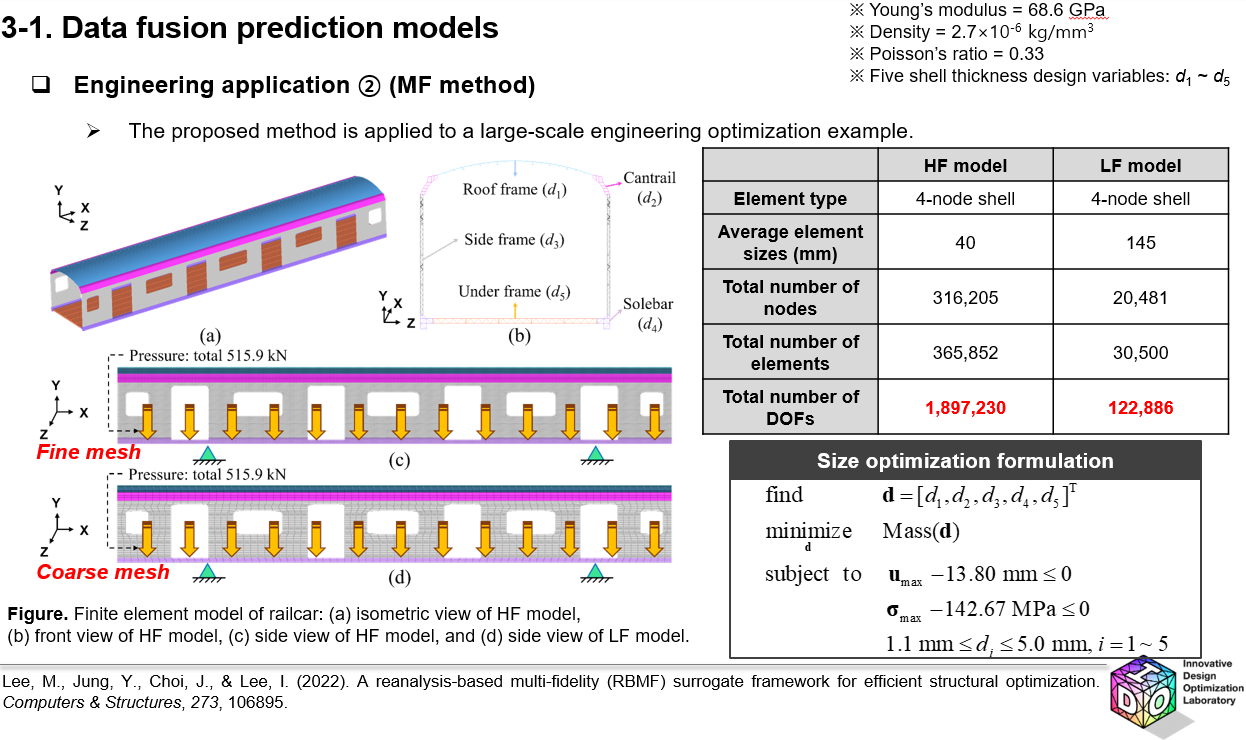

### ※ **예제 문제**
* **실습목표:** 선택된 Output에 대한 대리모델 구성 (정확성/효율성 측면에서 비교)
* **설계변수 개수:** 5개
* **설계공간:** 1.1<x<sub>1</sub><5, 1.1<x<sub>2</sub><5, 1.1<x<sub>3</sub><5, 1.1<x<sub>4</sub><5, 1.1<x<sub>5</sub><5
* **Output:** Bending loading condition일때 solebar의 수직방향으로의 처짐량
* **계산시간:** HF model (193초), LF model (3초)

In [3]:
from __future__ import print_function, division
import numpy as np
from matplotlib import pyplot as plt
from smt.applications import MFK
%matplotlib inline

from scipy import linalg
from smt.utils import compute_rms_error

from smt.problems import Sphere, NdimRobotArm, Rosenbrock
from smt.sampling_methods import LHS
from smt.surrogate_models import LS, QP, KPLS, KRG, KPLSK, GEKPLS, MGP
try:
    from smt.surrogate_models import IDW, RBF, RMTC, RMTB
    compiled_available = True
except:
    compiled_available = False

try:
    import matplotlib.pyplot as plt
    plot_status = True
except:
    plot_status = False

import scipy.interpolate

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm

import pandas as pd

## **Steps 1-3: Training data 불러오기**

In [4]:
# HF 인풋 데이터
# df1 = pd.read_csv('/content/drive/MyDrive/2024_동계산학협동강좌/Engineering_data/HF15_data.csv')
df1 = pd.read_csv('HF15_data.csv')
HF_data = df1.to_numpy()
xt_HF = HF_data[:,:5]

# LF 인풋 데이터
# df2 = pd.read_csv('/content/drive/MyDrive/2024_동계산학협동강좌/Engineering_data/LF100_data.csv')
df2 = pd.read_csv('LF100_data.csv')
LF_data = df2.to_numpy()
xt_LF = LF_data[:,:5]

In [5]:
print("HF input data",xt_HF)
print("LF input data",xt_LF)

HF input data [[3.18526542 2.11776589 3.27774438 1.33224192 1.98143467]
 [1.24589381 4.67175462 1.96342476 1.97002309 3.01940674]
 [4.711109   4.7917362  4.11716604 2.27151478 3.996545  ]
 [4.93290318 3.43240273 1.78446647 4.27744655 2.71057275]
 [3.85373284 1.63849792 3.70312468 3.77409036 4.33005241]
 [3.54532702 2.47011398 1.61018789 3.46503265 1.83244016]
 [2.33182495 2.79296167 2.16985632 1.64836015 2.33761768]
 [4.3232608  4.32958348 3.46254542 4.13311761 1.1295069 ]
 [2.4750839  1.29830627 4.53299219 2.47832608 2.65254472]
 [1.82234585 1.5006993  1.33433481 1.56856945 3.83262564]
 [4.18947141 2.14959698 4.93191349 4.99205935 3.39633894]
 [2.84286427 3.81783051 4.39280722 4.54654069 4.74554303]
 [2.05711764 4.08450468 3.00327073 2.78999417 3.51469944]
 [3.06971664 3.63978546 2.62449618 3.31522024 1.48987738]
 [1.48795685 3.05288659 2.73248085 2.94477222 4.61751702]]
LF input data [[3.18526542 2.11776589 3.27774438 1.33224192 1.98143467]
 [1.24589381 4.67175462 1.96342476 1.970023

In [6]:
yt_HF = HF_data[:,5:]
yt_LF = LF_data[:,5:]

In [7]:
# 차원 및 초기 데이터 개수
ndoe_HF = xt_HF.shape[0] # 초기 HF 데이터 개수
ndoe_LF = xt_LF.shape[0] # 초기 LF 데이터 개수
ndim = xt_HF.shape[1] # 설계 변수 개수 (차원)
print("HF training data 개수",ndoe_HF)
print("LF training data 개수",ndoe_LF)
print("설계변수 개수",ndim)

HF training data 개수 15
LF training data 개수 100
설계변수 개수 5


## **Step 4: 대리 모델 구성 (Multi-fidelity prediction model: Co-Kriging)**

In [8]:
# 대리모델링 (Main process, Co Kriging)
initial_theta = [0.1]*ndim # 초기 하이퍼파라미터 설정
sm_MF = MFK(theta0 = initial_theta, theta_bounds = [1e-6, 20], use_het_noise = False,
         propagate_uncertainty = False, n_start = 1)
sm_MF.set_training_values(xt_LF, yt_LF, name = 0) # LF 데이터 입력
sm_MF.set_training_values(xt_HF, yt_HF) # HF 데이터 입력
sm_MF.train() # 하이퍼파라미터 최적화

# 하이퍼파라미터 변화
print("initial theta values",  initial_theta)
print("optimal theta values",  sm_MF.optimal_theta)

___________________________________________________________________________
   
                                    MFK
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 15
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.5024450
initial theta values [0.1, 0.1, 0.1, 0.1, 0.1]
optimal theta values [array([0.00255599, 0.02881824, 0.16717779, 0.03515879, 0.00182193]), array([0.0003649 , 0.03745839, 0.00279161, 0.01030253, 0.01807511])]


## **Step 5: 모델 검증**

In [9]:
# 모델 검증용 데이터 생성
# df_test = pd.read_csv('/content/drive/MyDrive/2024_동계산학협동강좌/Engineering_data/HF100_data.csv')
df_test = pd.read_csv('HF100_data.csv')
HF_test = df_test.to_numpy()
xtest = HF_test[:,:5]
ytest = HF_test[:,5:]

ntest = xtest.shape[0]
print(ntest)

100


___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 100
   
   Predicting ...
   Predicting - done. Time (sec):  0.0149348
   
   Prediction time/pt. (sec) :  0.0001493
   


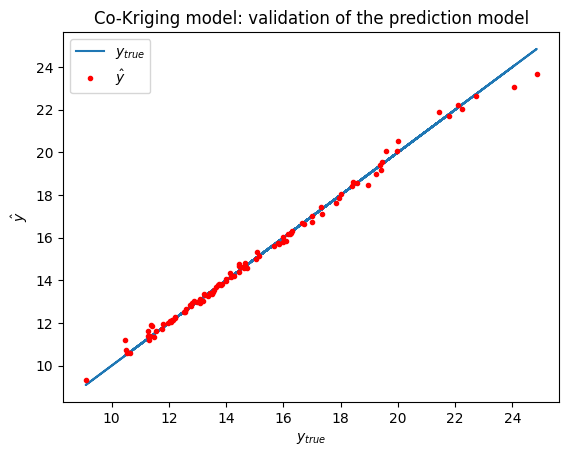

In [10]:
# Prediction of the validation points
y_pred = sm_MF.predict_values(xtest) # 최적화된 하이퍼파라미터가 적용된 크리깅 평균값 예측 모델

if plot_status:
    # Plot the function, the prediction and the 95% confidence interval based on
    # the MSE
    fig = plt.figure()
    plt.plot(ytest, ytest, '-', label='$y_{true}$')
    plt.plot(ytest, y_pred, 'r.', label='$\hat{y}$')

    plt.xlabel('$y_{true}$')
    plt.ylabel('$\hat{y}$')

    plt.legend(loc='upper left')
    plt.title('Co-Kriging model: validation of the prediction model')

if plot_status:
    plt.show()

In [11]:
from sklearn.metrics import mean_squared_error, r2_score

# The root mean squared error
print("Root mean squared error(RMSE): %.5f"
      % mean_squared_error(ytest, y_pred)**0.5)

# R2
print("R2: %.5f"
      % r2_score(ytest,y_pred))

Root mean squared error(RMSE): 0.24275
R2: 0.99452


## **최적화 수행**

### ※ **예제 문제**
* **실습목표:** 대리모델 기반 최적화 수행
* **설계변수 개수:** 5개
* **설계공간:** 1.1<x<sub>1</sub><5, 1.1<x<sub>2</sub><5, 1.1<x<sub>3</sub><5, 1.1<x<sub>4</sub><5, 1.1<x<sub>5</sub><5
* **초기설계:** 모두 3.0 mm
* **목적함수:** 전동차의 무게
* **제한조건:** Bending loading condition일때 solebar의 수직방향으로의 처짐량 <= 20 mm

In [12]:
from scipy.optimize import minimize, differential_evolution
import numpy as np
import matplotlib.pyplot as plt

In [13]:
def obj(x): # 목적함수
    x = x[np.newaxis,:]
    return 1.3*x[0,0]+1*x[0,1]+3*x[0,2]+1.1*x[0,3]+3.8*x[0,4]

In [14]:
def constr(x): # 제한조건함수
    x = x[np.newaxis,:]
    return -np.squeeze(sm_MF.predict_values(x))+20

In [15]:
bnds = [(1.1,5),(1.1,5),(1.1,5),(1.1,5),(1.1,5)] # 경계값

In [16]:
ineq_cons = {'type': 'ineq', 'fun': constr} # 제한조건 설정

In [17]:
initial_points = np.array([3.0, 3.0, 3.0, 3.0, 3.0], dtype = 'float64') # 초기값

In [18]:
print("Initial input",initial_points)
print("Initial obj",obj(initial_points))

Initial input [3. 3. 3. 3. 3.]
Initial obj 30.599999999999998


In [19]:
# 최적화 수행
result = minimize(obj,initial_points,method='SLSQP',bounds=bnds,constraints=ineq_cons) # Gradient-based optimization

___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0011125
   
   Prediction time/pt. (sec) :  0.0011125
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0017817
   
   Prediction time/pt. (sec) :  0.0017817
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0042322
   
   Prediction time/pt. (sec) :  0.0042322
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0006199
   
   Prediction time/pt. (sec) :  0.0006199
   
________________________________________________

In [20]:
result

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 16.553915552055088
       x: [ 1.100e+00  3.486e+00  1.629e+00  2.337e+00  1.100e+00]
     nit: 15
     jac: [ 1.300e+00  1.000e+00  3.000e+00  1.100e+00  3.800e+00]
    nfev: 135
    njev: 15

In [21]:
x_opt = result.x
f_opt = result.fun

print("Optimal input",x_opt)
print("Minimum",f_opt)
print("Contraint_violation",constr(x_opt))

Optimal input [1.1        3.48646294 1.6290898  2.33653019 1.1       ]
Minimum 16.553915552055088
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0068426
   
   Prediction time/pt. (sec) :  0.0068426
   
Contraint_violation 2.7891644549526973e-10
